In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
LINUX_COLS = ['i',
              'rx_desc',
              'rx_bytes',
              'tx_desc',
              'tx_bytes',
              'instructions',
              'cycles',
              'ref_cycles',
              'llc_miss',
              'c1',
              'c1e',
              'c3',
              'c3e',
              'c6',
              'c7',
              'joules',
              'timestamp']

JOULE_CONVERSION = 0.000061

TIME_CONVERSION_khz = 1./(2899999*1000)

DVFS_VALS = ['0xc00', '0xe00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1900', '0x1a00']
QPS_VALS = ['50000', '100000', '200000', '400000', '600000']

In [3]:
def total_col_cpu(df, col):
    df_diff = df[col].diff().dropna()
    df_diff = df_diff[df_diff >= 0]
    if col == "joules":
        df_diff = df_diff * JOULE_CONVERSION
    if col == "timestamp":
        df_diff = df_diff * TIME_CONVERSION_khz
    return df_diff.sum()

In [13]:
def parse_logs_per_dvfs_qps(dir):
    dfs_dvfs = {}
    for dvfs in DVFS_VALS:
        dfs_dvfs[dvfs] = {}
        for qps in os.listdir(dir):
            dfs_dvfs[dvfs][qps] = []
    for qps in os.listdir(dir):
        for file in os.listdir(dir + qps):
            if file.split('_')[1] == "latency":
                continue
            dvfs_val = file.split('_')[0]
            df = pd.read_csv(dir + qps + "/" + file, sep=" ", names=LINUX_COLS, index_col=[0])
            dfs_dvfs[dvfs_val][qps].append(df)
    return dfs_dvfs

def parse_logs_per_qps(dir):
    dfs_qps = {}
    for qps in os.listdir(dir):
        dfs_qps[qps] = []
        for file in os.listdir(dir + qps):
            if file == "mutilate_latency":
                continue
            df = pd.read_csv(dir + qps + "/" + file, sep=" ", names=LINUX_COLS, index_col=[0])
            dfs_qps[qps].append(df)
    return dfs_qps
        
def compute_col_per_qps(df_dict, col):
    col_qps = {}
    for qps in df_dict:
        col_qps[qps]= []
        for df in df_dict[qps]:
            total_col = total_col_cpu(df, col)
            col_qps[qps].append(total_col)
    return col_qps
    
def col_qps_hist(col_dict, col, dvfs, x_min, x_max):
    fig, ax = plt.subplots()
    fig.set_figheight(3)
    for qps in col_dict:
        _, _, _ = ax.hist(col_dict[qps], bins=5)
    plt.title("Total " + col + " for different QPS, DVFS " + dvfs + " (16 cores, single run)")
    plt.ylabel("# Logs per " + col + " bin")
    plt.xlabel(col)
    plt.legend(col_dict.keys())
    plt.xlim(x_min - 100, x_max + 100)
    plt.show()


In [5]:
df_dict = parse_logs_per_dvfs_qps("mcd_ixgbe_logs/")
df_dict_muster = parse_logs_per_dvfs_qps("mcd_ixgbe_muster_logs/")

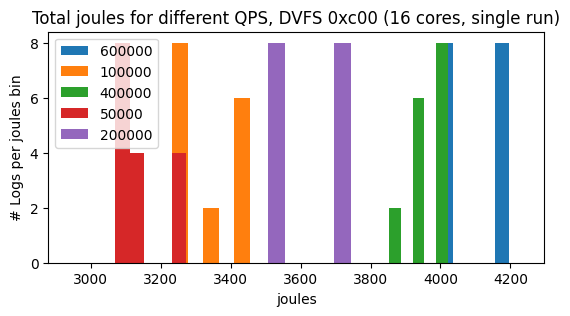

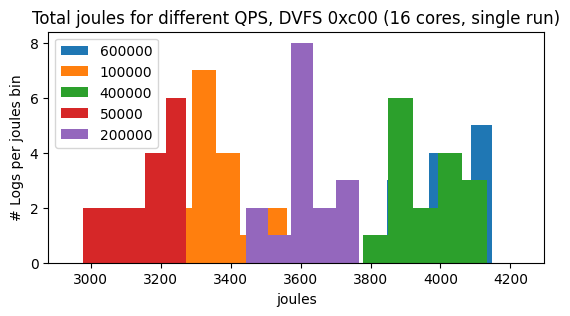

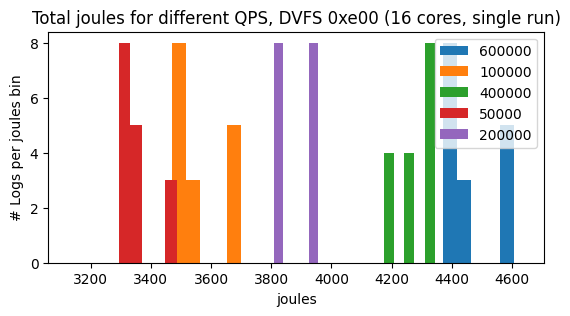

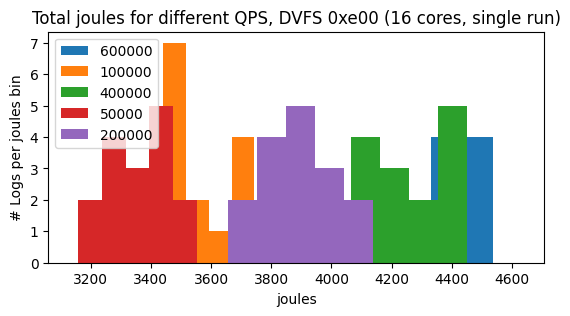

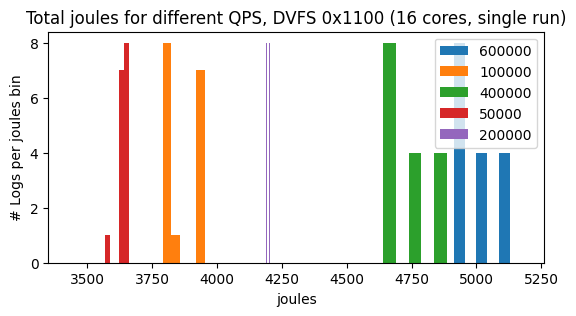

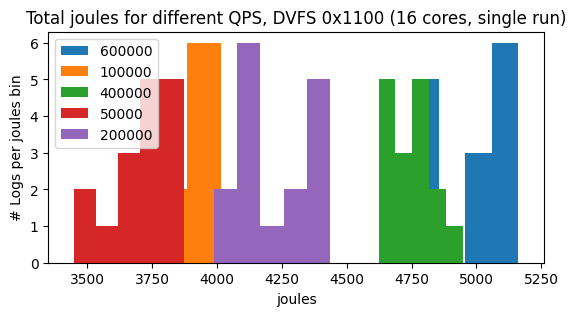

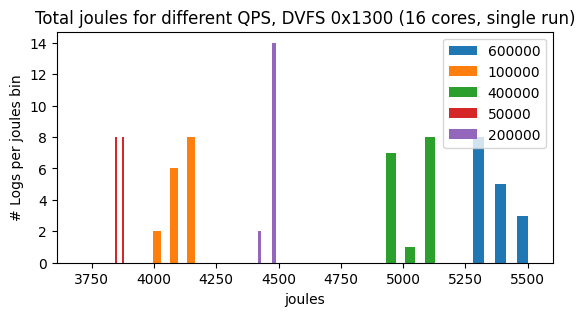

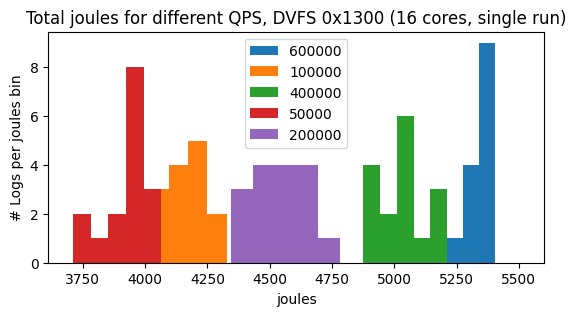

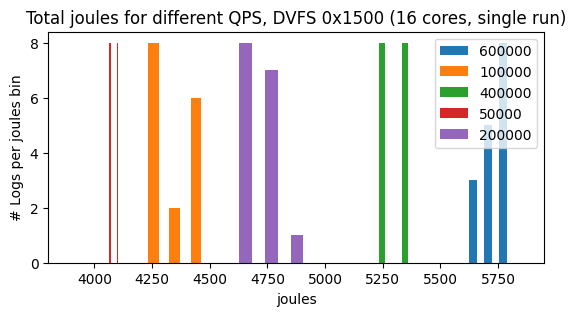

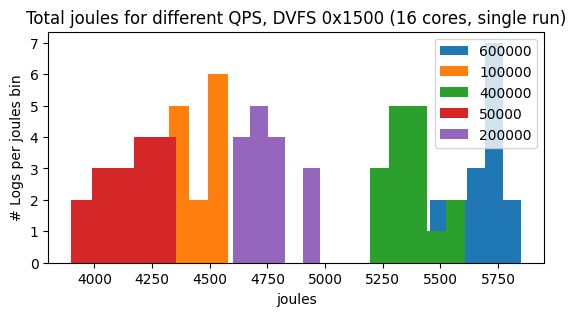

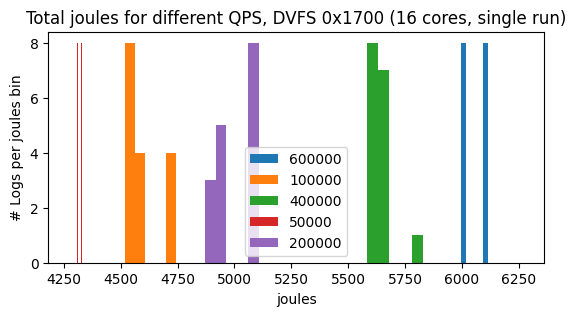

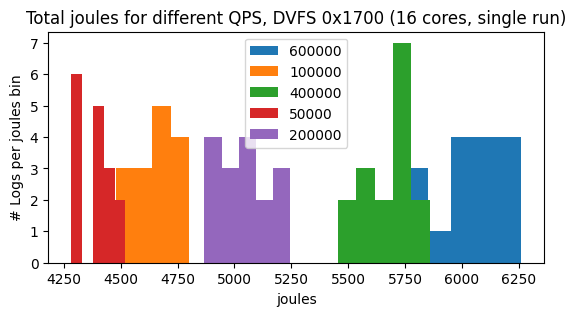

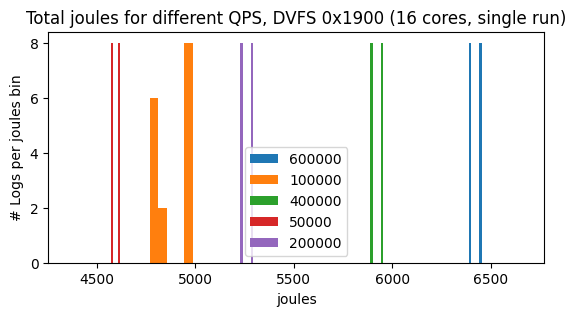

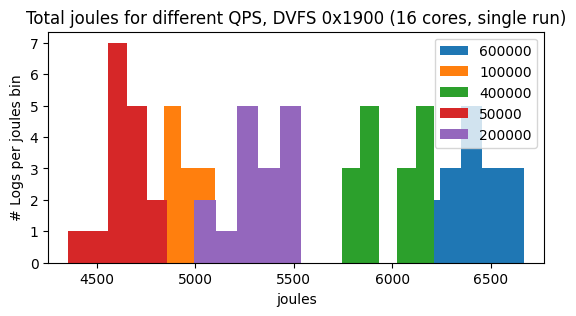

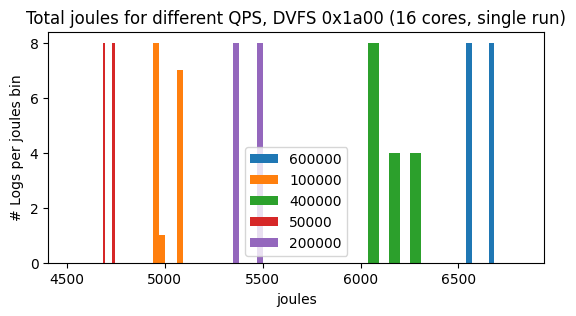

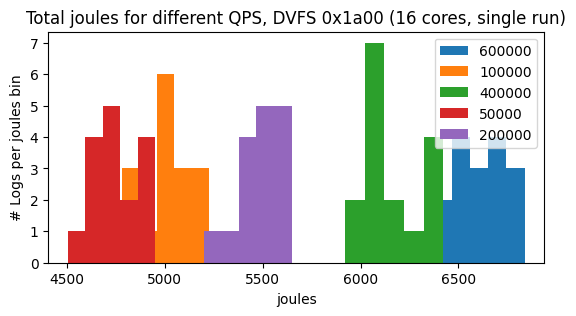

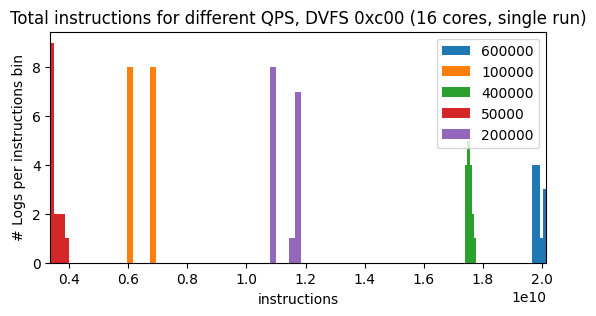

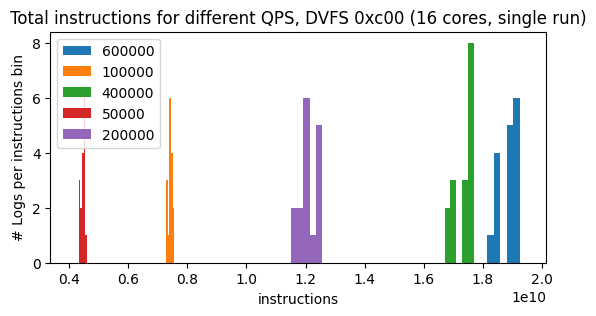

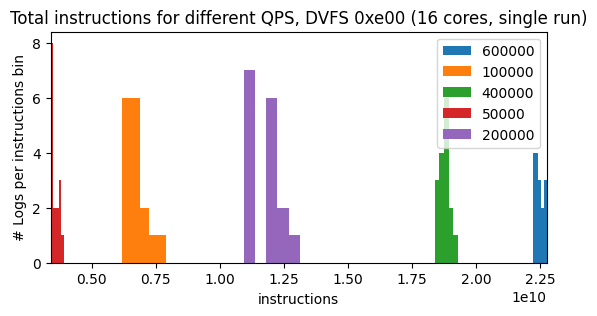

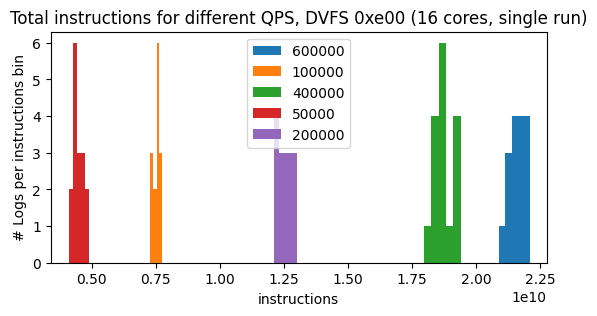

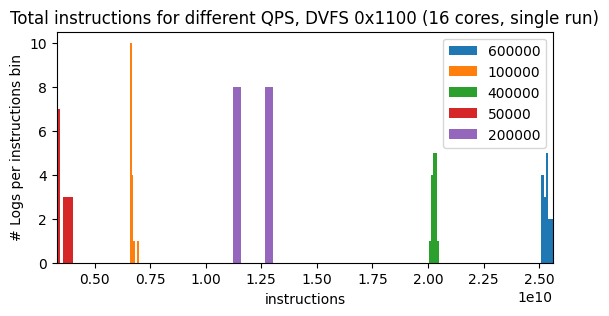

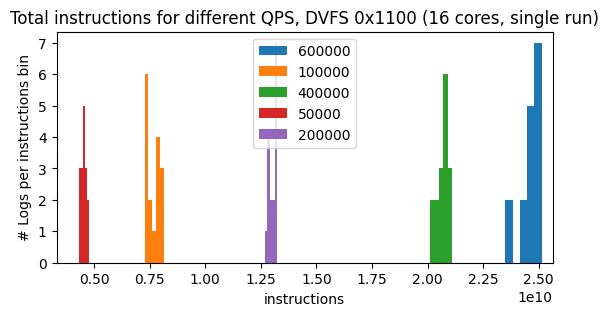

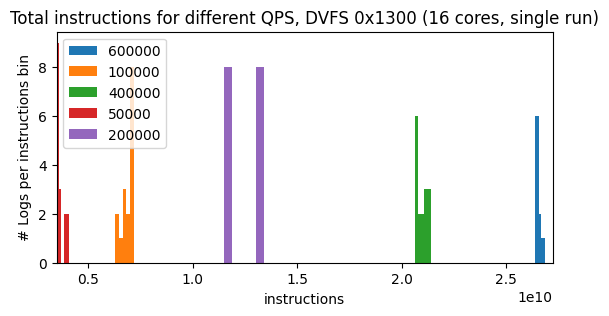

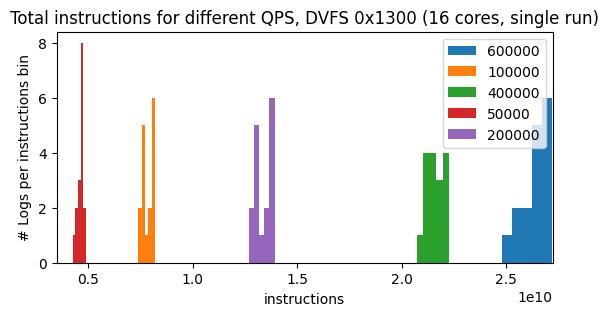

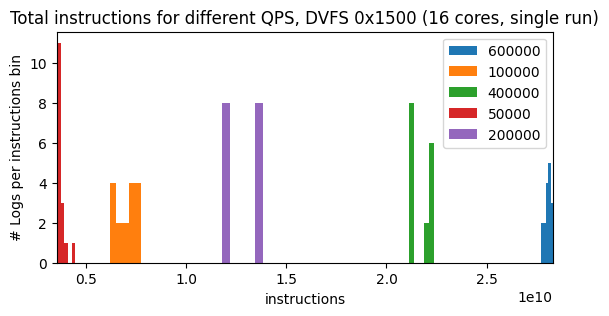

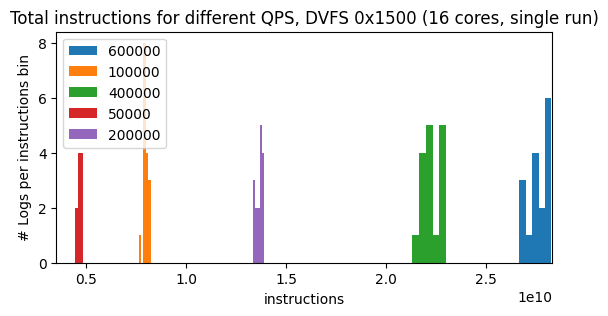

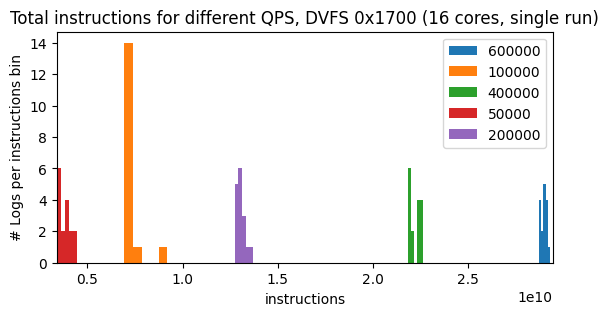

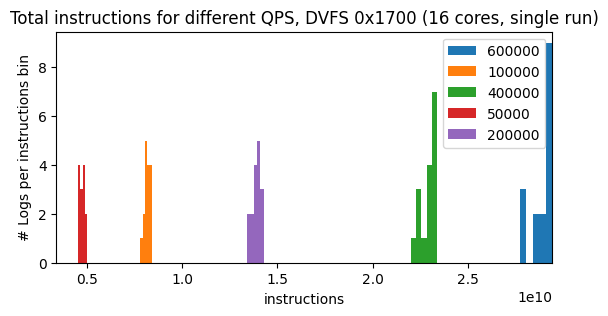

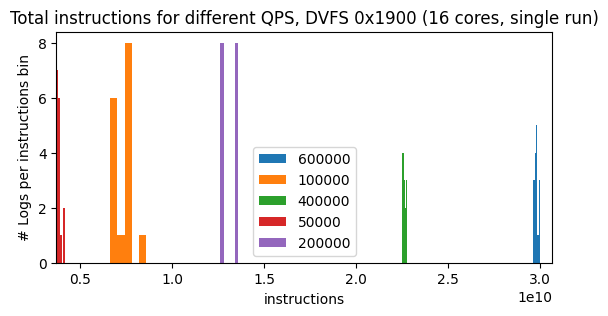

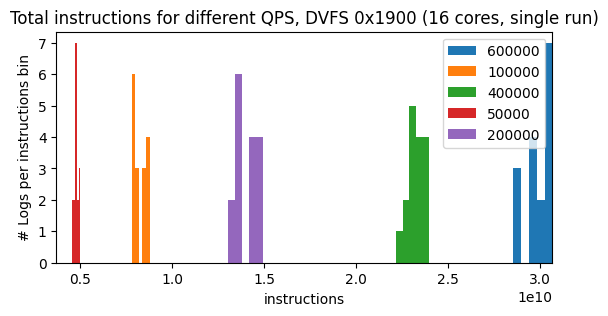

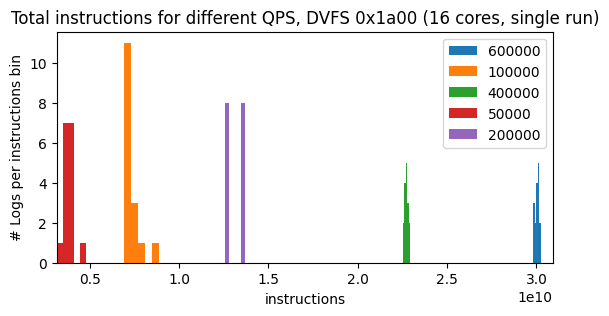

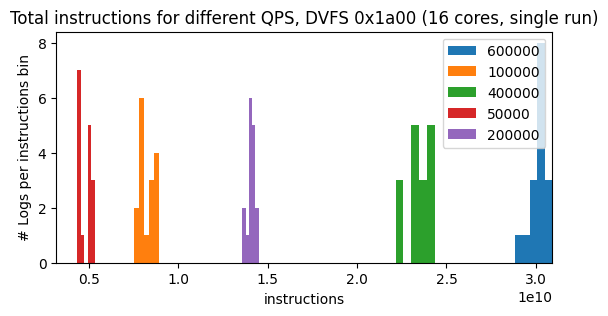

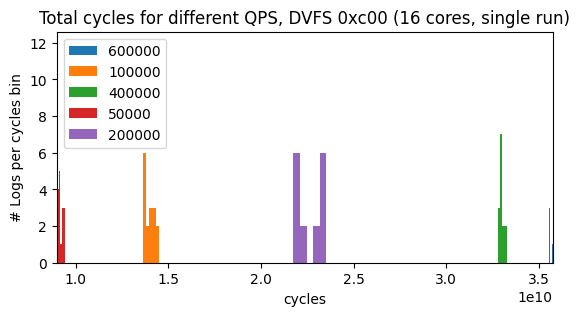

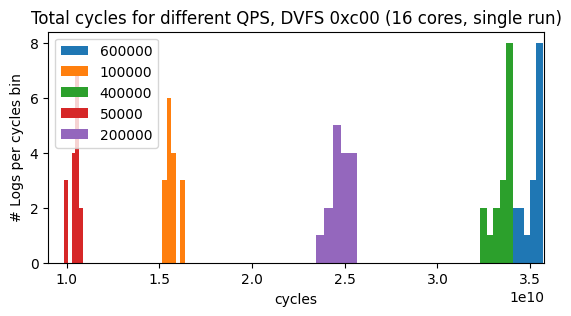

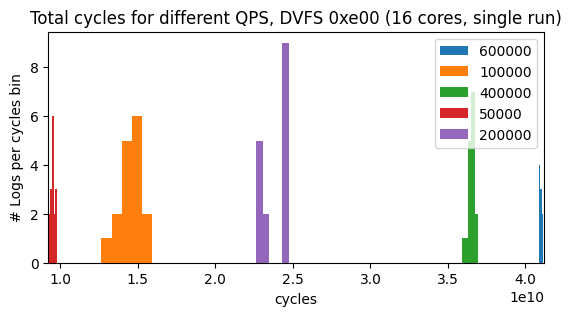

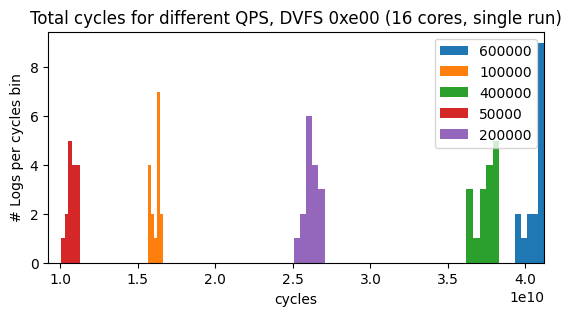

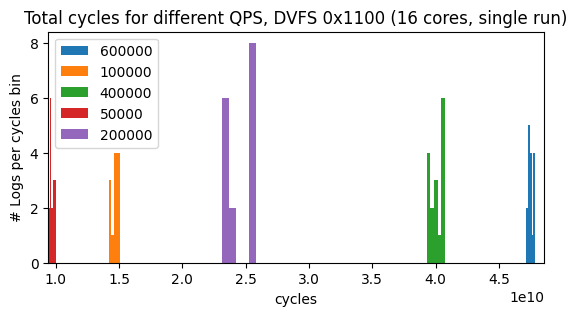

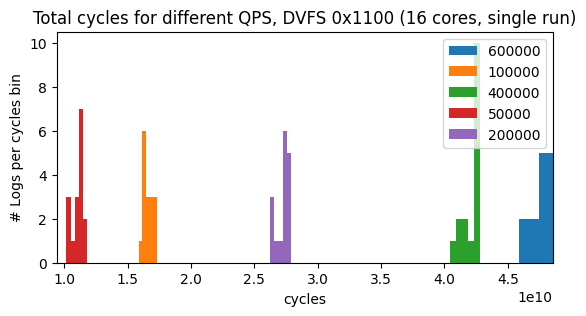

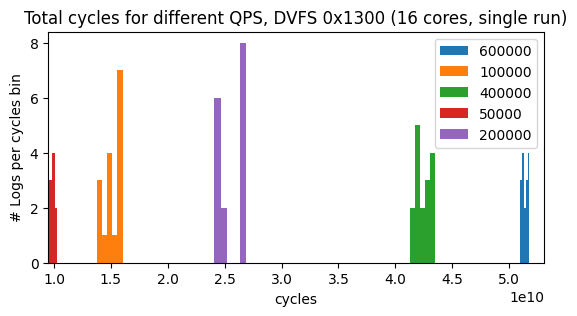

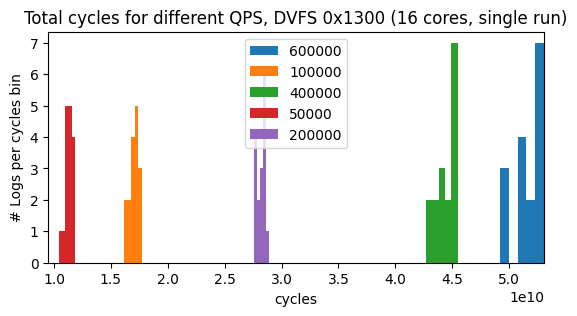

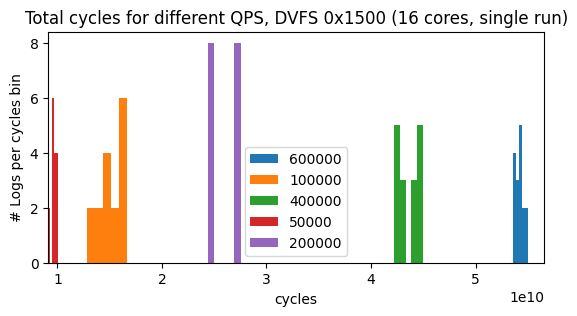

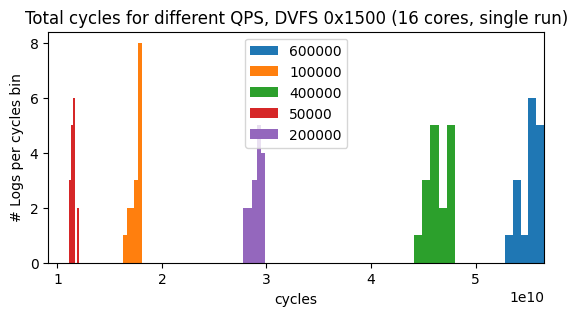

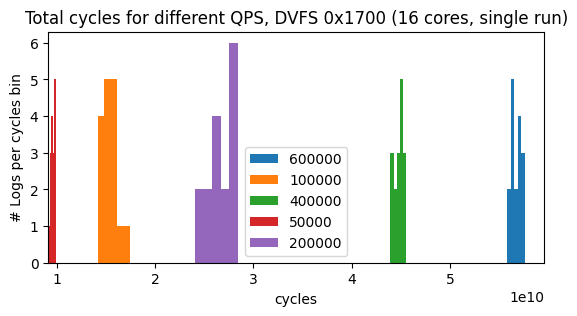

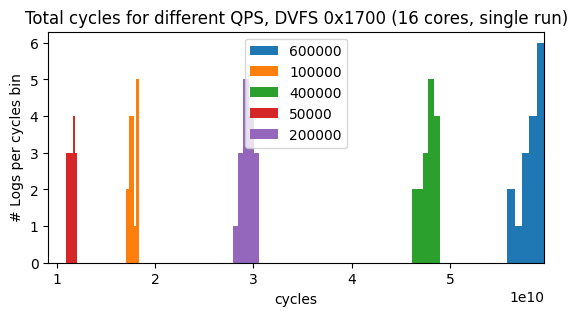

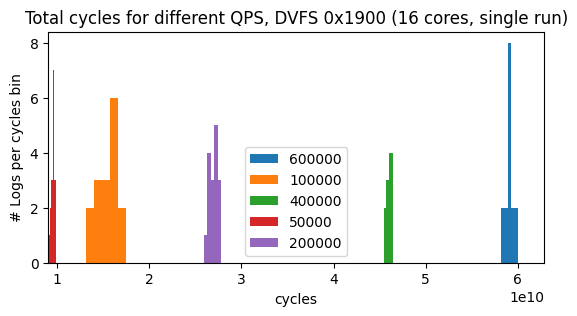

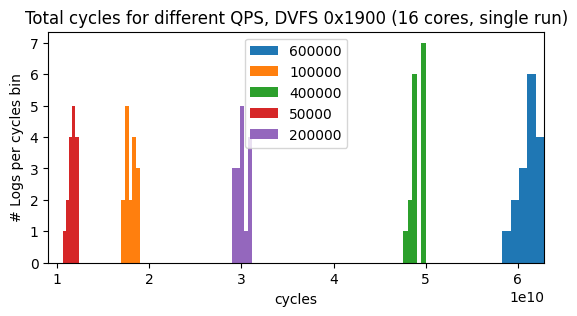

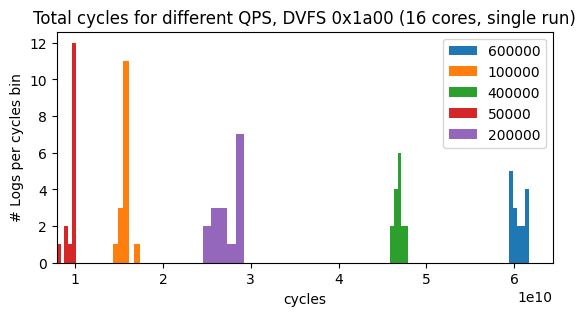

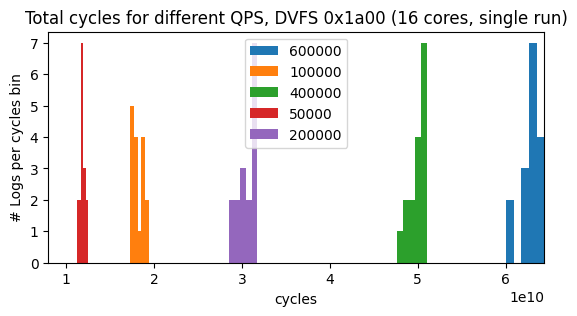

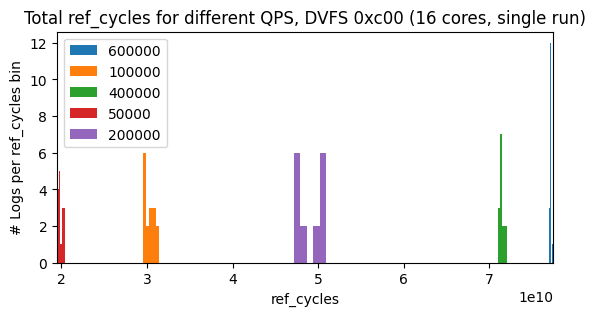

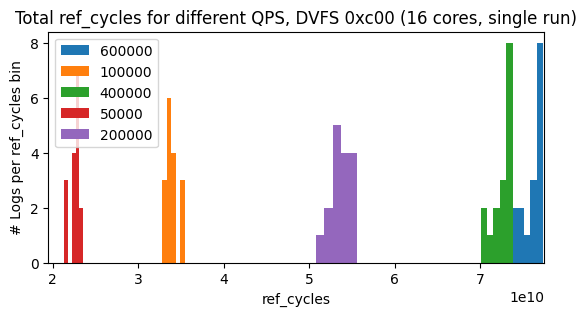

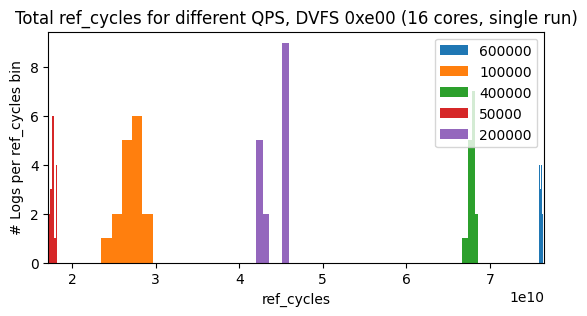

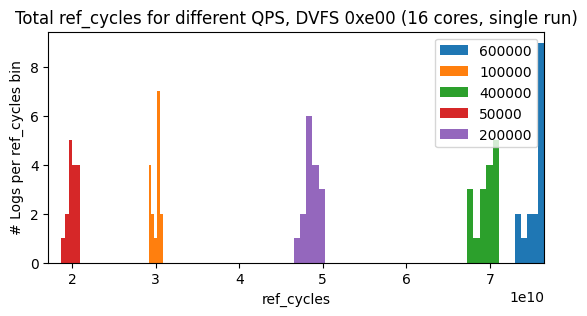

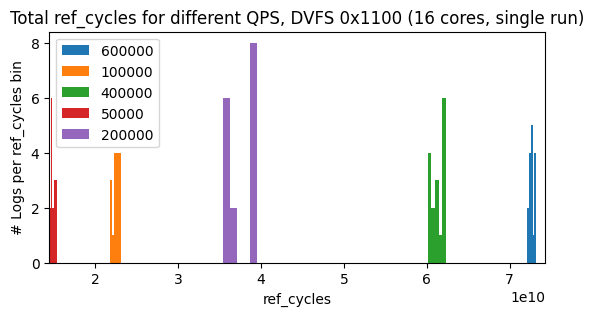

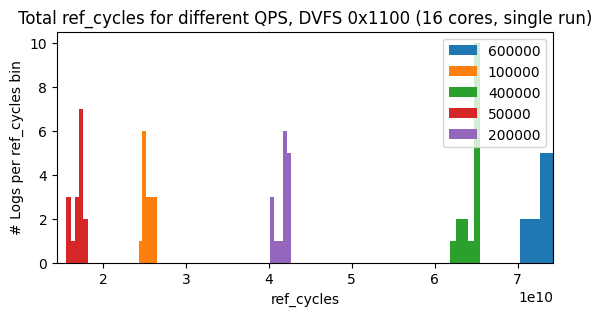

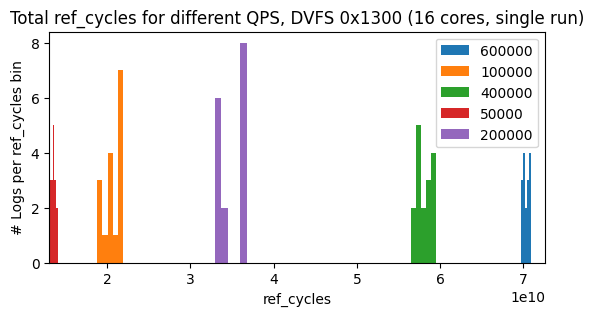

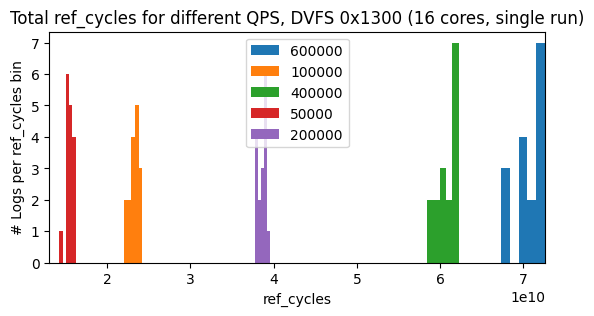

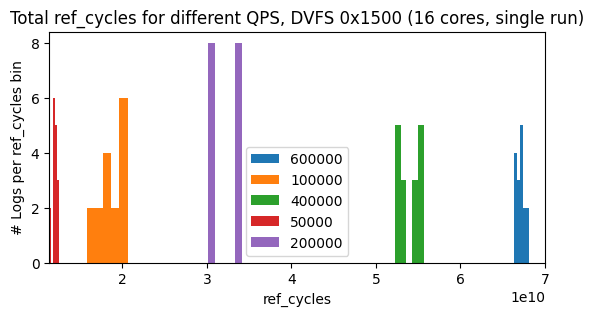

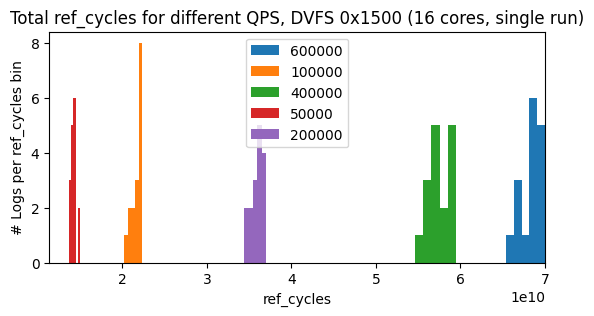

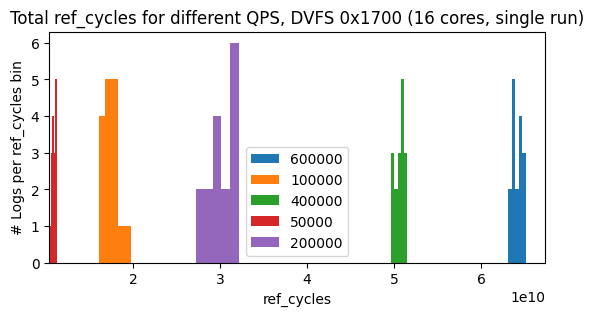

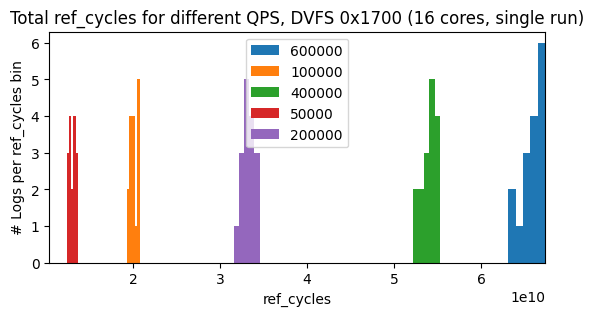

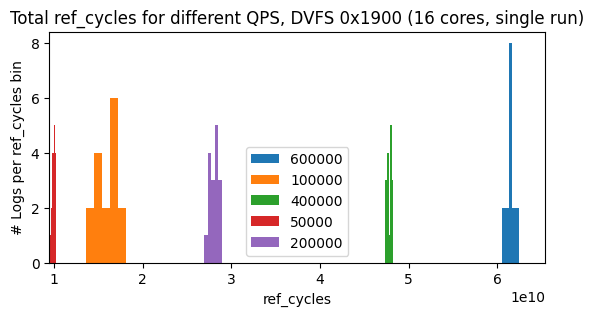

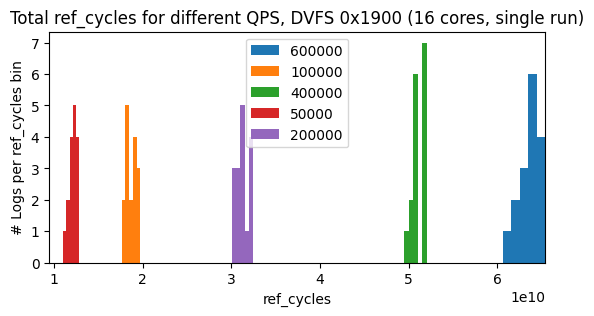

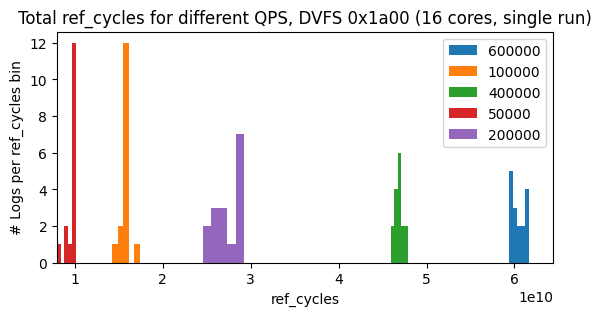

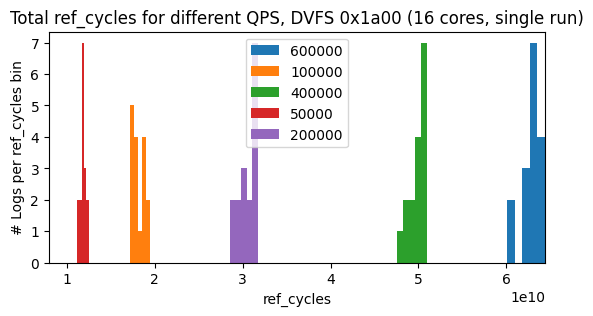

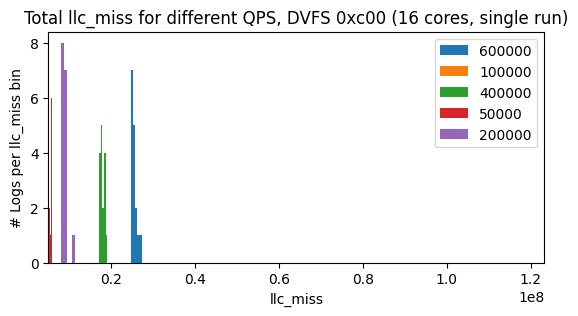

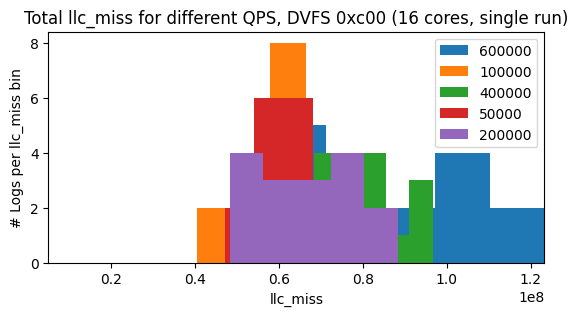

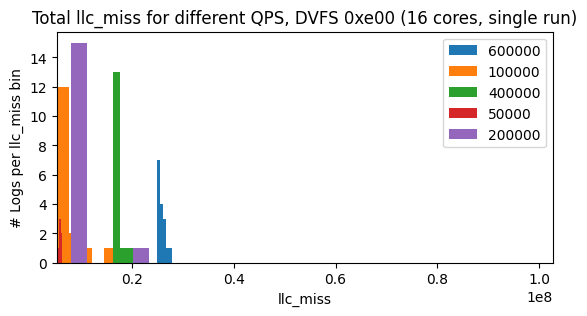

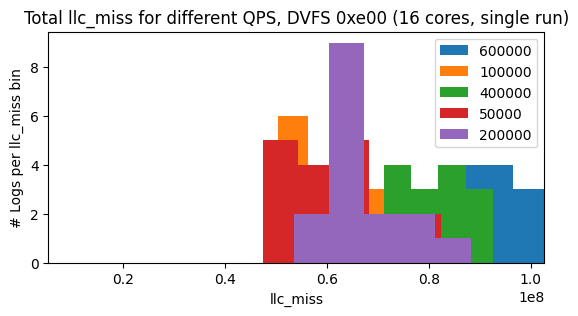

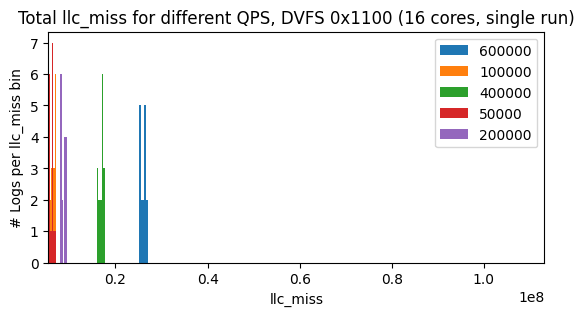

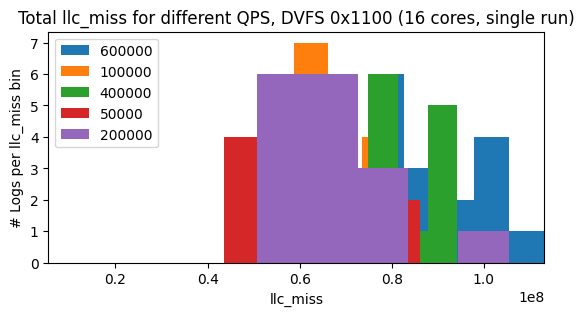

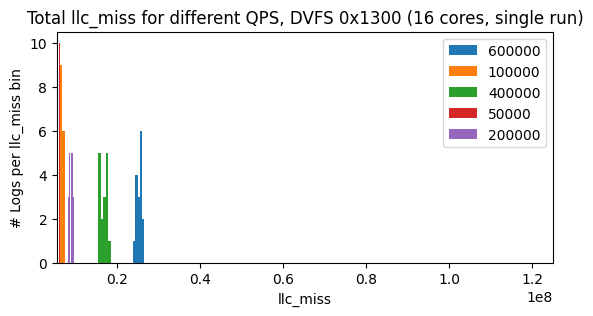

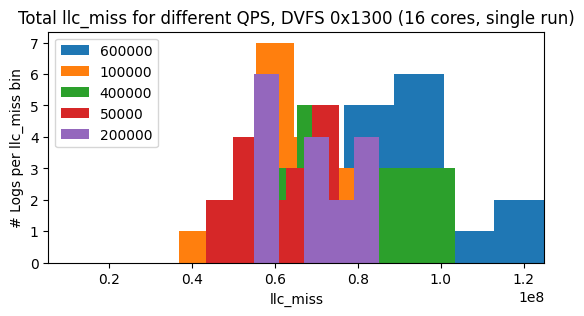

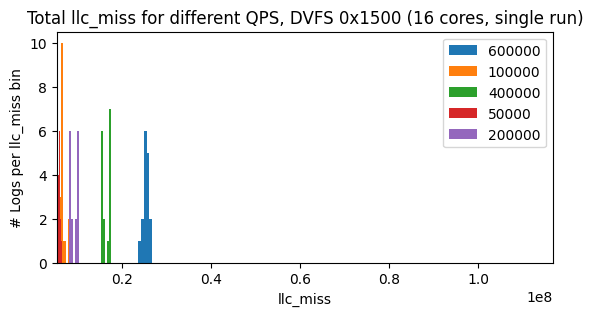

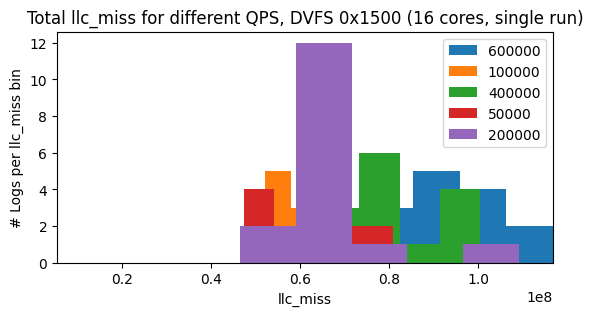

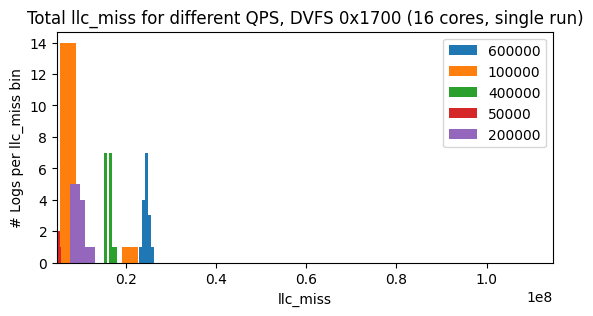

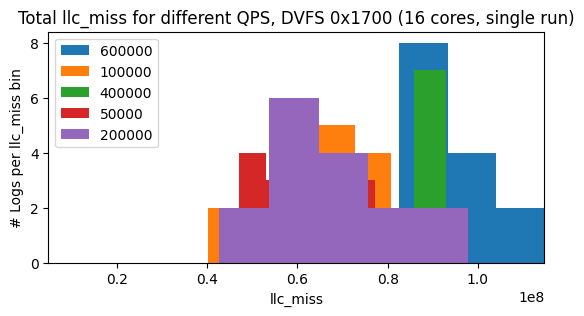

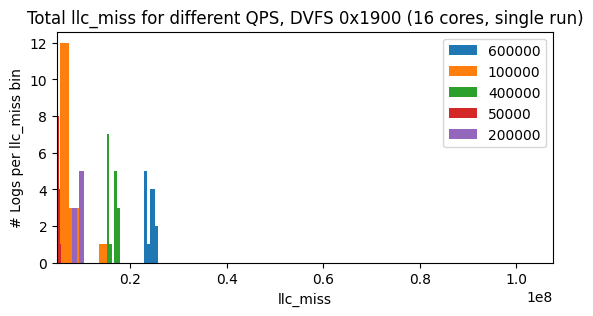

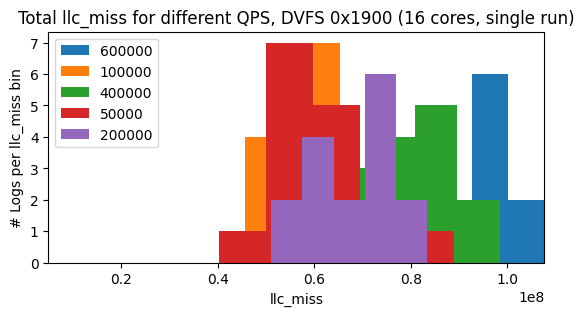

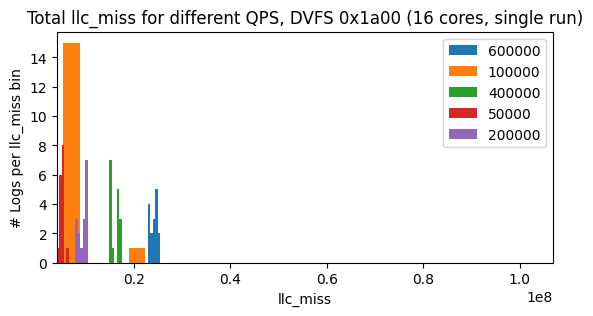

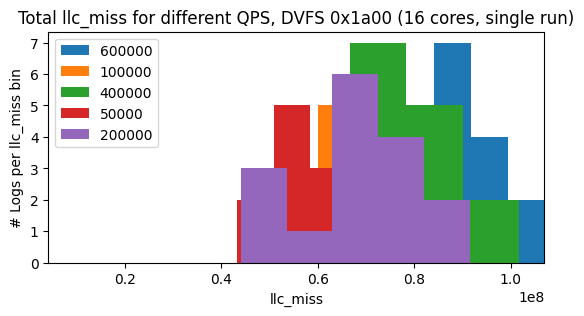

In [14]:
for col in ["joules", "instructions", "cycles", "ref_cycles", "llc_miss"]:
    for dvfs in DVFS_VALS:
        col_dict = compute_col_per_qps(df_dict[dvfs], col)
        col_muster_dict = compute_col_per_qps(df_dict_muster[dvfs], col)

        col_max = 0
        col_muster_max = 0
        col_min = 2**64
        col_muster_min = 2**64

        for qps in col_dict:
            if min(col_dict[qps]) < col_min:
                col_min = min(col_dict[qps])
            if max(col_dict[qps]) > col_max:
                col_max = max(col_dict[qps])          
        for qps in col_muster_dict:
            if min(col_muster_dict[qps]) < col_muster_min:
                col_muster_min = min(col_muster_dict[qps])
            if max(col_muster_dict[qps]) > col_muster_max:
                col_muster_max = max(col_muster_dict[qps])
                
        x_min = min(col_min, col_muster_min)
        x_max = max(col_max, col_muster_max)
        col_qps_hist(col_dict, col, dvfs, x_min, x_max)
        col_qps_hist(col_muster_dict, col, dvfs, x_min, x_max)